In [ ]:
!unzip /content/drive/MyDrive/DataSet/KYR_B_imaging.zip

# 데이터 디렉토리 로드 

In [588]:
import os 
import cv2 
import pandas as pd 
from glob import glob
from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as cm 

## 파일 디렉토리 설정 

In [589]:
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr3' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr2 74' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr5' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr7' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr4' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/nswr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr6' '/content/KYR_B_imaging' 
!rm -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱'

cp: cannot stat '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr3': No such file or directory
cp: cannot stat '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr2 74': No such file or directory
cp: cannot stat '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr5': No such file or directory
cp: cannot stat '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr7': No such file or directory
cp: cannot stat '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8': No such file or directory
cp: cannot stat '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr4': No such file or directory
cp: cannot stat '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr6': No such file or directory


## 이미지 디렉토리 dir_df 생성 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


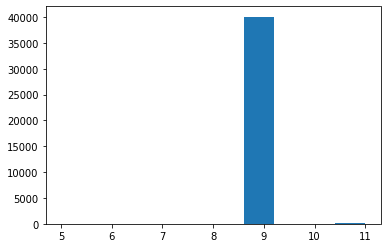

In [601]:
#폴더 디렉토리
folder_dir = glob('/content/KYR_B_imaging/*')

#이미지 디렉토리 
image_name = []
for i in folder_dir:
  image_name.extend(glob(f'{i}/*.jpg'))
image_name.sort()

dir_df = pd.DataFrame(image_name)
dir_df['Key_id'] =0
dir_df.columns = ['dir','key']

#디렉토리에서 마지막 이미지 번호만 때옴 
for i in range(len(dir_df)):
  dir_df['key'][i] =  dir_df['dir'][i].split('/')[-1]

#Key 값 + 이미지 순번 되어 있던 거 Key 값만 남김 
dir_df['key'] = dir_df['key'].apply(lambda x:x[:-8])
#key값이 8보다 작은 것들 인덱스
temp = dir_df[dir_df['key'].apply(lambda x:len(x))==8].index
#8자리인 key값들 0 붙여서 9자리로 만듬 
dir_df.loc[dir_df['key'].apply(lambda x:len(x))==8,'key'] = dir_df.iloc[temp]['key'].apply(lambda x: '0'+x)

plt.hist(dir_df['key'].apply(lambda x:len(x)))
plt.show()

##환자정보- snsb_df 생성 

In [631]:
columns = ['성명',
 '병록번호',
 '만나이',
 '교육년수',
 'SVLT_recall_total_score_z',
 'SVLT_Delayed_recall_z',
 'SVLT_recognition_score_z',
 'RCFT_immediate_recall_z',
 'RCFT_delayed_recall_z',
 'RCFT_recognition_score_z',
 'K_MMSE_total_score_z',
 'SNSB_II_Domain_Attention_z',
 'SNSB_II_Domain_Language_z',
 'SNSB_II_Domain_Visuospatial_z',
 'SNSB_II_Domain_Memory_z',
 'SNSB_II_Domain_Frontal_z']

In [ ]:
snsb_df = pd.read_csv('/content/drive/MyDrive/DataSet/202202_김예림/SNSB_integerated.csv')
snsb_df = snsb_df.drop([2098,2591]) #병록번호 없는 행 제거 <- 결측치 
snsb_df['병록번호'] = snsb_df['병록번호'].apply(lambda x : str(int(x)))

snsb_df = snsb_df[columns]

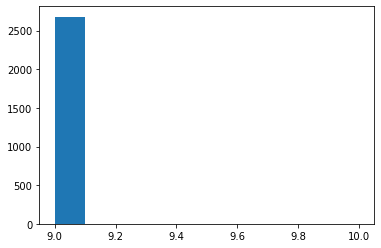

In [633]:
target_length = [4,5,6,7,8] #<- 수정해야 하는 병록번호 갯수들 

#병록 번호의 length 가 target_length에 속하는 것들 모두 0 더해서 9자리로 맞춤 
for length in target_length: 
  difference = 9 - length #추가해줘야 하는 자릿수 
  add = '0' *difference #추가해줘야 하는 자릿수 만큼 0추가 
  
  modified_id = snsb_df.loc[snsb_df['병록번호'].map(len)==length,'병록번호'].apply(lambda x : add+x)
  snsb_df.loc[snsb_df['병록번호'].map(len)==length,'병록번호'] = modified_id

#위 로직으로 보정되지 않은 것들 임베딩으로 보정 아래 dict keys 값들이 보정되지 않은 값임 
mis_keys_dict = {'17043':'170435316','19021':'190215496','20004':'200045636','97026':'970266683','094018957':'940189576'}
mis_keys_keys = list(mis_keys_dict.keys())

#위 mis_keys_dict를 토대로 값 보정 진행 
temp = dir_df.loc[dir_df['key'].apply(lambda x : x in mis_keys_keys),'key'].apply(lambda x:mis_keys_dict[x])
dir_df.loc[dir_df['key'].apply(lambda x : x in mis_keys_keys),'key'] = temp

plt.hist(snsb_df['병록번호'].map(len))
plt.show()

## Key 값 미스매칭 확인 

In [634]:
csv_key = list(set(snsb_df['병록번호']))
img_key = list(set(dir_df['key']))
csv_key.sort()
img_key.sort()
csv_key = np.array(csv_key)
img_key = np.array(img_key)

error = [] 
for i in range(len(img_key)):
  if img_key[i] in csv_key:
    pass
  else:
    error.append(i)

print(img_key[error])

['000758836-1' '030338456-1' '040145556-1' '050236926-1' '090374796-1'
 '100402746-1' '120010356-1' '870133669-1' '920033543-1' '930236559-1'
 '930257597-1' '970682600-1']


# 초기 작업 - 이미지 장수 조절
- 이미지 갯수는 20개인 경우가 가장 많지만 이미지를 살리기 위해 19장으로 진행 
- 우선 19장보다 작은 경우는 모두 제하고 진행 

- 키값별로 이미지 갯수를 구하는 리스트 생성 
- 키값별 19장 indexing 
- indexing 대로 추출해서 새로운 DF에 input 

## Key 별 이미지 갯수 리스트 생성 

Key 별 이미지 장수 확인 

In [607]:
def check_images(dir_df,key):
  length = dir_df[dir_df['key']==key]['dir'].values.shape[0]
  return length

#이미지 장수 연산 
keys = list(set(dir_df['key'])) 
images_length = pd.DataFrame(keys)[0].apply(lambda x: check_images(dir_df,x)) #키 값별로 이미지의 장수들 계산 
images_length.value_counts()

20     1336
40      182
60       55
80       13
19       10
100       7
23        3
24        3
10        3
25        2
39        2
38        2
22        2
17        2
21        2
9         2
59        1
52        1
96        1
33        1
16        1
28        1
55        1
150       1
31        1
57        1
12        1
Name: 0, dtype: int64

images_length 데이터 프레임 생성 (key,이미지 장수)

In [608]:
length_df = pd.DataFrame([keys,images_length]).T
length_df.columns = ['key','image_length']
length_df['image_length']  = length_df['image_length'].map(int)

In [609]:
standard = 19 # 통일 시킬 이미지 장 수 기준 

Standard를 기준으로 less over 분할 

In [610]:
# 조정이 필요한 장 수 초과하는 것들만 추림 
length_df_over = length_df[length_df['image_length']>standard]

#19장 보다 적은 경우 
length_df_less = length_df[length_df['image_length']<standard]

## dir에서 추출해서 new_dir_df 생성 

length_df_over 갖고 진행 

In [611]:
# 제거해야 하는 사진 갯수 구하는 함수 
def return_length_diff(length_df,index):
  temp_key = length_df_over.iloc[index]['key']
  temp_length = length_df_over.iloc[index]['image_length']
  length_diff = abs(int(standard-temp_length)) #2로 아직 나누지 않음 
  return length_diff

# 앞뒤로 몇개의 이미지를 잘라야 하는 지 갯수를 알려 줌 
def return_drop_counts(length_df,index):
  length_diff = return_length_diff(length_df, index )
  front_drop = int(length_diff/2)
  rear_drop = length_diff - front_drop
  return front_drop, rear_drop

# front_drop, rear_drop = return_drop_counts(length_df_over,0)

# 키값으로 인덱스 호출
def return_images_indexes(dir_df,length_df,index):
  temp_key = length_df['key'].values[index]
  temp_indexes = dir_df[dir_df['key'] == temp_key].index
  return temp_indexes

#키값으로 호출한 인덱스에서 필요한 장수 standard 갯수만큼 인덱스만 남김 
def droped_indexes(dir_df,length_df,index):
  temp_keys = return_images_indexes(dir_df,length_df,index)
  front_drop, rear_drop = return_drop_counts(length_df,index)
  indexes = temp_keys[front_drop:-rear_drop]
  return indexes

#19장 씩 dir 잘라서 보관할 새로운 빈 DF 생성  
new_dir_df = pd.DataFrame(np.zeros(1618*19*2).reshape(-1,2))
new_dir_df.columns = dir_df.columns

#19장씩 뽑아서 새로운 빈 DF에 넣기 
for index in tqdm(range(1618)):
  new_dir_df.iloc[index*19:(index+1)*19,:]  = dir_df.loc[droped_indexes(dir_df,length_df_over,index)]

100%|██████████| 1618/1618 [00:14<00:00, 108.46it/s]


장수 조절 되었나 확인 

In [612]:
#이미지 장수 확인
keys = list(set(new_dir_df['key'])) 
temp = pd.DataFrame(keys)[0].apply(lambda x: check_images(new_dir_df,x)) #키 값별로 이미지의 장수들 계산 
temp.value_counts()

19    1618
Name: 0, dtype: int64

361이 나오는 것은 아직 length_df_less가 다 들어오지 않은 것들 때문 

# 초기 작업 - z score 임베딩 생성

In [635]:
def zscore_Embedding(value):
  if value >= -1.0:
    result = 1
  else:
    result = 0
  return result

Embedding_columns = snsb_df.columns[4:]

for column in Embedding_columns:
  snsb_df[f'E_{column}'] = snsb_df[column].map(zscore_Embedding)